In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime

# Preparation of the dataset

Load the dataset into pandas and take a look at the first few lines

In [21]:
df = pd.read_csv('../data/covid_testing_data.csv')
df.head(2)

,country,country_code,year_week,level,region,region_name,new_cases,tests_done,population,testing_rate,positivity_rate,testing_data_source
0,Austria,AT,2020-W15,national,AT,Austria,1954,12339,8858775.0,139.285624,15.835967,Manual webscraping
1,Austria,AT,2020-W16,national,AT,Austria,773,58488,8858775.0,660.226724,1.321639,Manual webscraping


We are interested in the development of the national covid testing over the year, so first we turn the dataset into a timeseries and filter out the countries of interest.

Note: the subnautional results sum up to full national, so those are also filtered out

In [22]:
df.year_week = pd.to_datetime((df.year_week.astype('str')+'-1'), format="%G-W%V-%u")

# filter only the countries of interest
country_list = ['DE','DK','RO','ES','SE']
df_filt = df[df.country_code.isin(country_list)].loc[(df.level) == 'national']
df_filt.set_index(df_filt['year_week'], inplace = True)
df_filt.tail(2)

,country,country_code,year_week,level,region,region_name,new_cases,tests_done,population,testing_rate,positivity_rate,testing_data_source
year_week,,,,,,,,,,,,
2020-12-28,Sweden,SE,2020-12-28,national,SE,Sweden,41343,201011,10230185.0,1964.881378,20.567531,TESSy
2021-01-04,Sweden,SE,2021-01-04,national,SE,Sweden,39485,201011,10230185.0,1964.881378,19.643204,TESSy


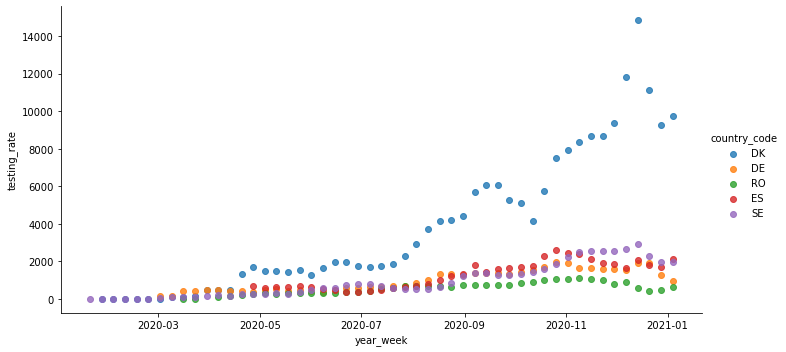

In [23]:
# make a quick plot of the testing rate by country with a handy seaborn plot
sns.lmplot(x='year_week', y="testing_rate", data=df_filt, hue='country_code',
           legend=True, fit_reg=False, aspect = 2)

## Resample

The simplest way to resample this time series to a monthly format is to just resample without additional effort. However, the data here is presented as total results (cases, tests etc) during that calendar week. When converting to timestamps, pandas requires us to pick a day of the week and in a later resample will consider that day as the basis for monthly data. In cases when a week starts in one month but ends in another, a simple resample will attribute the data to the first month.

To correct for that obvious error, I'm using an assumption that the number of cases each day was the same for the whole week of the recorded data. Note that this is also incorrect, since we've seen that reports vary by day of the week quite significantly. The hope here is that it generates less inaccuracy than the simple resampling. In an ideal world one would check both, since it doesnt cost much time with this size of a dataset

### Upsample to daily data

Since I'm doing a total reconstruction of the data, I will have to recalculate the rates, selecting only the cases

In [24]:
# using a dummy dataframe object
s = df_filt[['year_week','country_code','tests_done','new_cases','population']]

The upsampling is based on the assumptions above. The data is grouped by country then upsampled and data copied with forward fill. Each week is then grouped and split evenly among the records.

In [25]:
df_upsample = pd.DataFrame()

# fill out empty days by a proportional share of cases and tests 
# and recalculate testing rates/positivity rates
for name, group in s.groupby(['country_code']):
    df_daily = group.asfreq('d', method='ffill')
    df_daily.tests_done /= df_daily.tests_done.groupby(df_daily.year_week).transform('count').values
    df_daily.new_cases /= df_daily.new_cases.groupby(df_daily.year_week).transform('count').values
    df_upsample = df_upsample.append(df_daily)

In [26]:
# One drawback of forward filling for weeks is that the final record
# will be the monday of the last week.
# isnt a problem when downsampling later
df_upsample.tail(2)

,year_week,country_code,tests_done,new_cases,population
year_week,,,,,
2021-01-03,2020-12-28,SE,28715.857143,5906.142857,10230185.0
2021-01-04,2021-01-04,SE,201011.000000,39485.000000,10230185.0


### Downsample to monthly data

The data are grouped by country and resampled to monthly data using built in methods. Population column can just be left as the average of all entries since it is the same for all entries

In [157]:
df_downsample = (df_upsample
                .groupby(df_upsample['country_code'])
                .resample('1M')
                .agg({'tests_done': np.sum
                      ,'new_cases': np.sum
                      ,'population': np.mean
                     })
                .reset_index()
              )
df_downsample.set_index(df_downsample['year_week'], inplace = True)

Then the monthly rates can be recalculated. This does produce an artifact that the testing rate of the last month (Jan 2021) is going to look low, since we only have one week wort of data. This can be corrected, but isnt that important for now

In [158]:
df_downsample['testing_rate'] = df_downsample.tests_done / (df_downsample.population / 1e5)
df_downsample['positivity_rate'] = df_downsample.new_cases / df_downsample.tests_done
df_downsample.tail(2)

,country_code,year_week,tests_done,new_cases,population,testing_rate,positivity_rate
year_week,,,,,,,
2020-12-31,SE,2020-12-31,1.141280e+06,182184.428571,10230185.0,11156.004091,0.159632
2021-01-31,SE,2021-01-31,2.871586e+05,57203.428571,10230185.0,2806.973397,0.199205


There are 1600 cases in Romania during the first month with only a handful of tests performed.
Thus the datapoint is way off. Here we could use the positivity rate from the original dataset which is 0.06

In [60]:
df_downsample.loc[(df_downsample.positivity_rate > 1),'positivity_rate'] = 0.06

Text(0, 0.5, 'Testing rate')

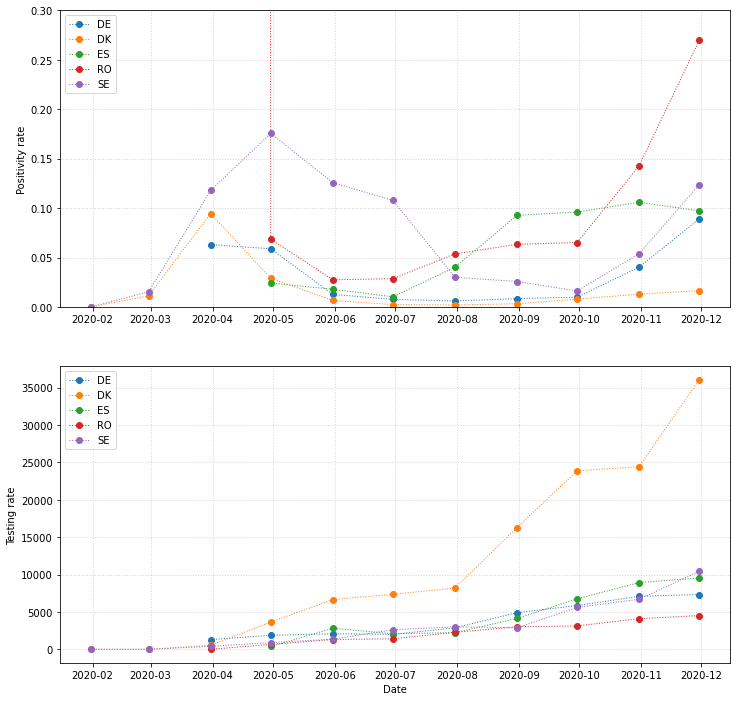

In [162]:
data = df_downsample.loc['2020-01-01':'2020-12-30']

fig, (ax,ax2) = plt.subplots(2, 1, figsize=[12, 12])

ax.grid(b=True, which='both', axis='both', linestyle=':', linewidth=1,alpha=0.5)
ax2.grid(b=True, which='both', axis='both', linestyle=':', linewidth=1,alpha=0.5)

for key, grp in data.groupby(['country_code']):
    ax.plot(grp['year_week'],grp['positivity_rate'], lw=1, ls=':', marker='o',label = key)
    ax2.plot(grp['year_week'],grp['testing_rate'], lw=1, ls=':', marker='o',label = key)
        
ax.legend()
ax2.legend()
ax.set_ylim(0,0.3)

ax2.set_xlabel('Date')

ax.set_ylabel('Positivity rate')
ax2.set_ylabel('Testing rate')

Lets look at a single country to see if there is any evidence in being reactionary. We would expect there to be an increase in testing rates a few weeks after the increase in positivity rats. That is in fact the case with Sweden in the first wave of the epidemic. While less pronounced, this is also the case with other countries

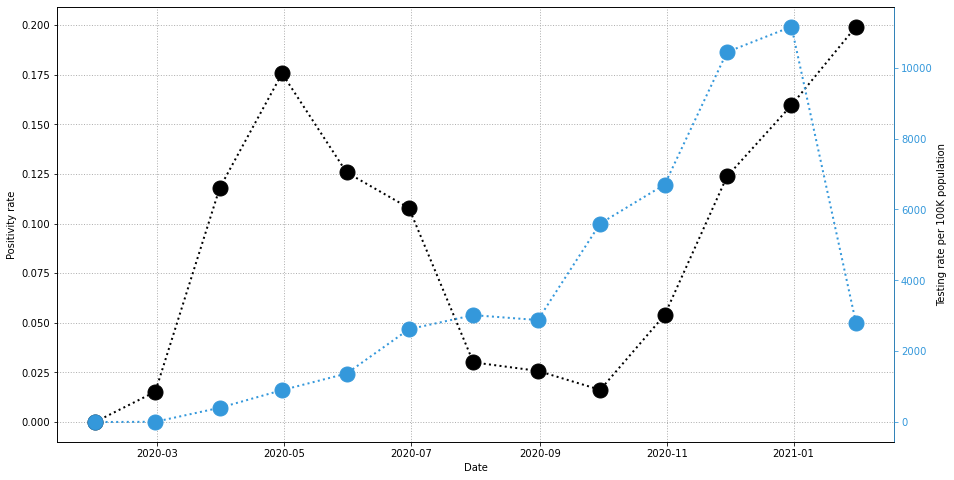

In [288]:
fig, (ax) = plt.subplots(1, 1, figsize=[15, 8])

ax2 = ax.twinx()
ax.grid(b=True, which='both', axis='both', linestyle=':', linewidth=1)

data = df_downsample.loc[df_downsample['country_code']=='SE']
color =  '#3498db'

ax.plot(data['year_week'],data['positivity_rate'], lw=2, ls=':',ms=15,  marker='o',label = key, c = 'k')
ax2.plot(data['year_week'],data['testing_rate'], lw=2, ls=':', ms=15, marker='o',label = key, c= color)

ax.set_ylabel('Positivity rate')
ax.set_xlabel('Date')

ax2.set_ylabel('Testing rate per 100K population')
ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y',which='both', colors=color)

### Comparison of testing development between countries

Regional differences make such comparisons purely academic. 
For meaningful conclusions one should be aware of political and societal differences between the countries.

These are nevertheless fun to do. For easy visual comparison, we're going to normalize the data to the same min max

In [272]:
from sklearn import preprocessing

Create a dataframe from just the testing rates for comparison

In [274]:
df_testing_rates = pd.DataFrame()

for name, group in df_downsample.loc['2020-01-01':'2020-12-30'].groupby(['country_code']):
    df_testing_rates = pd.concat([df_testing_rates, group.testing_rate.rename( name)], axis=1)

df_testing_rates = df_testing_rates.fillna(0)
df_testing_rates.head(5)

,DE,DK,ES,RO,SE
2020-01-31 00:00:00,0.000000,0.036907,0.000000,0.000000,0.289061
2020-02-29 00:00:00,0.000000,5.282639,0.000000,0.000000,7.771120
2020-03-31 00:00:00,1299.672471,538.479767,0.000000,0.050036,402.234033
2020-04-30 00:00:00,1872.340253,3646.974366,384.232478,665.075776,900.955638
2020-05-31 00:00:00,2086.085784,6660.814510,2813.053420,1311.396015,1367.792609


Now plot the rates normalized from 0 - 1. Here we discard the magnitudes but preserve the changes. The results could be interpreted as quite similar visually

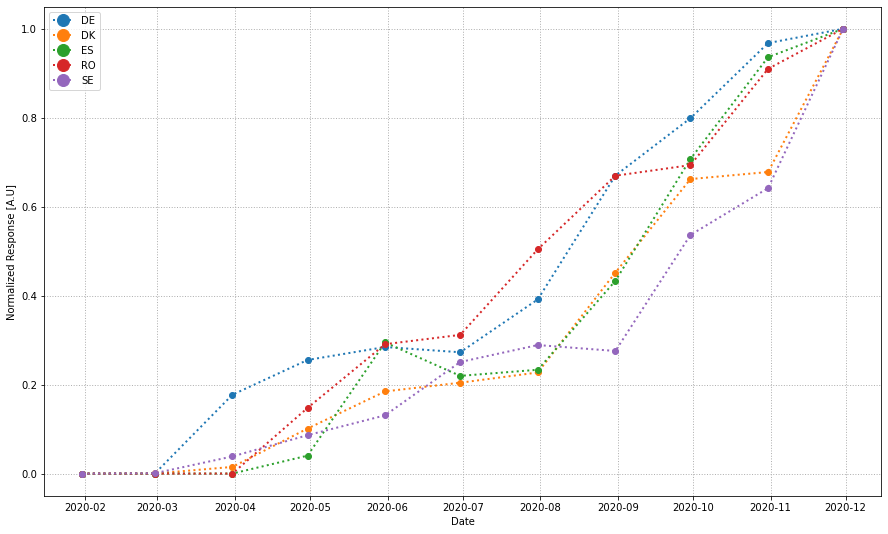

In [258]:
fig, (ax) = plt.subplots(1, 1, figsize=[15, 9])

ax.grid(b=True, which='both', axis='both', linestyle=':', linewidth=1)


for i in df_testing_rates.columns:
    
    var = preprocessing.minmax_scale(df_testing_rates[i])
    
    ax.plot(df_testing_rates.index,var,label=i, lw=2, ls=':', marker='o')
    

ax.set_ylabel('Normalized Response [A.U]')
ax.set_xlabel('Date')

ax2.set_ylabel('Humidity [RH]')
ax2.spines['right'].set_color(color)

ax2.tick_params(axis='y',which='both', colors=color)

# ax.set_ylim(-1.5,2.5)
# # ax.set_xlim(3250,4000)
ax.legend(markerscale=2)

Lets try to fit a simple exponential function and see how they compare

In [269]:
from scipy.optimize import curve_fit

def func(x, a, b,c):
    return c + a * np.exp(b * x)

DE [ 3.62588156e+03  1.15729134e-01 -3.69736533e+03]
DK [ 3.81223841e+03  2.35208261e-01 -4.51378862e+03]
ES [ 1.40826427e+03  2.14500059e-01 -1.77673691e+03]
RO [ 3.44347671e+03  8.92210876e-02 -3.74022014e+03]
SE [ 4.58961047e+02  3.12467052e-01 -3.38620789e+02]


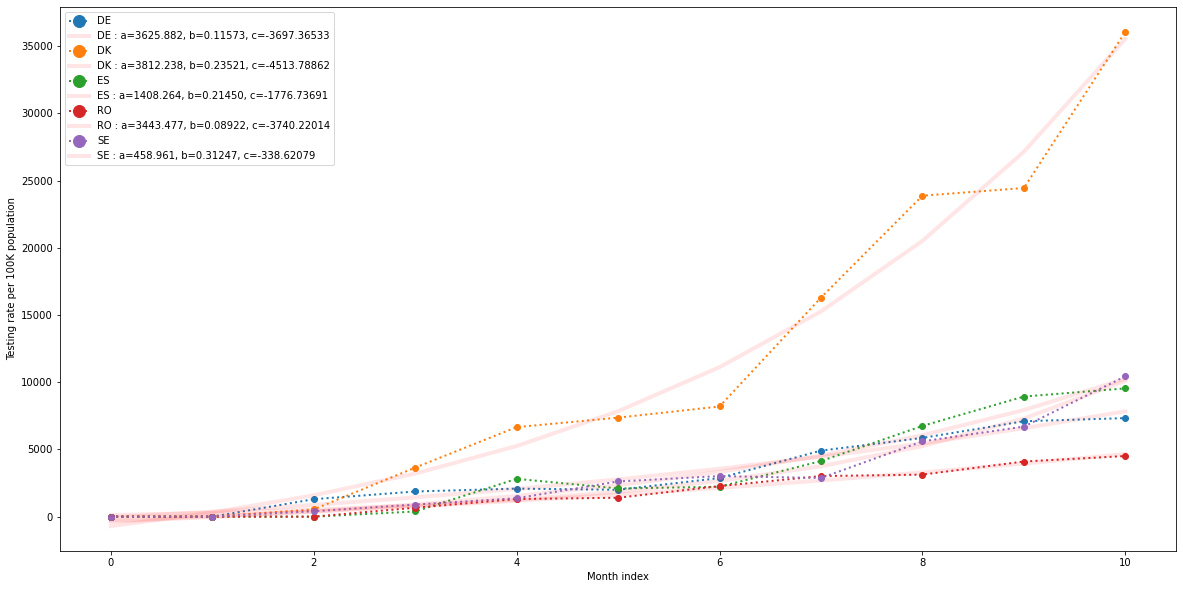

In [287]:
fig, (ax) = plt.subplots(1, 1, figsize=[20, 10])


for i in df_testing_rates.columns:
    var = df_testing_rates[i]#preprocessing.robust_scale(df_testing_rates[i])
    xdata = df_testing_rates.reset_index()
    ax.plot(xdata.index,var,label=i, lw=2, ls=':', marker='o')
    
    xdata = xdata.index

#     popt, pcov = curve_fit(func, xdata,var, p0=[0.1,1, 0],bounds=((0,0,0),(9,9,0.00000001)))
    popt, pcov = curve_fit(func, xdata,var, p0=[3,1, 0])#,bounds=((0,0,0),(9,9,0.00000001)))
    print(i, popt)
    ax.plot(xdata, func(xdata, *popt), 'r-', alpha = 0.1, lw = 4,
         label=i+' : a=%5.3f, b=%5.5f, c=%3.5f' % tuple(popt))
    ax.legend(markerscale=2)
    ax.set_ylabel('Testing rate per 100K population')
    ax.set_xlabel('Month index')

DE [ 0.95433626  0.11572828 -1.52220529]
DK [ 0.21188092  0.23520828 -0.66022821]
ES [ 0.26822694  0.21450006 -0.76257276]
RO [ 1.25641187  0.089221   -1.87766704]
SE [ 0.12547426  0.31246682 -0.80862563]


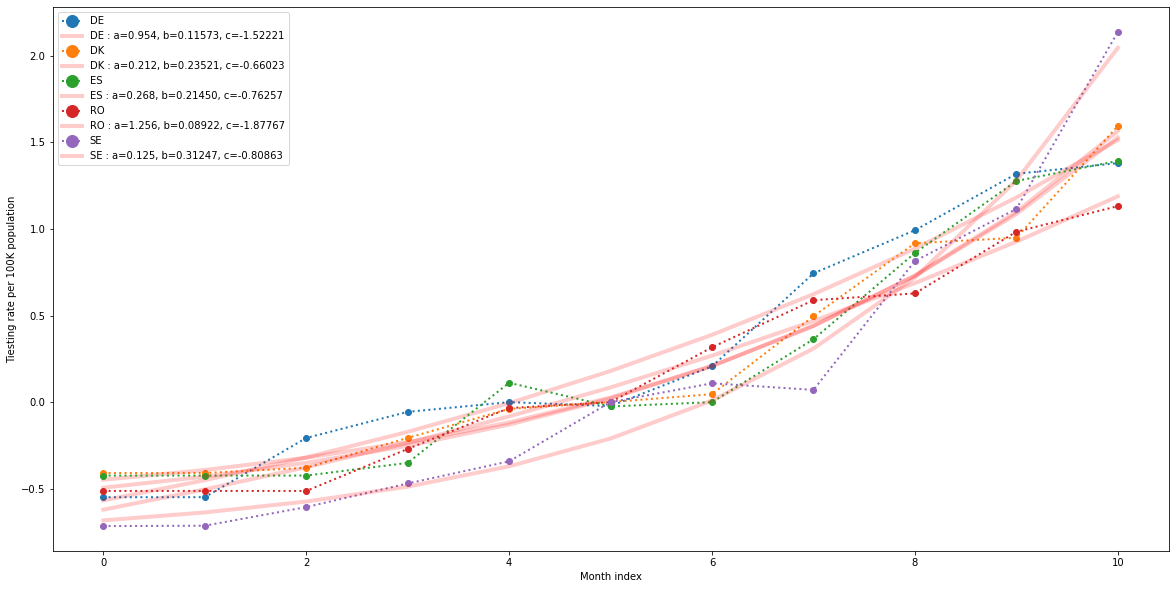

In [278]:
fig, (ax) = plt.subplots(1, 1, figsize=[20, 10])


for i in df_testing_rates.columns:
    var = preprocessing.robust_scale(df_testing_rates[i])
    xdata = df_testing_rates.reset_index()
    ax.plot(xdata.index,var,label=i, lw=2, ls=':', marker='o')
    
    xdata = xdata.index
    popt, pcov = curve_fit(func, xdata,var, p0=[1000,1, 0])
    print(i, popt)
    ax.plot(xdata, func(xdata, *popt), 'r-', alpha = 0.2, lw = 4,
         label=i+' : a=%5.3f, b=%5.5f, c=%3.5f' % tuple(popt))
    ax.legend(markerscale=2)
    ax.set_ylabel('Tiesting rate per 100K population')
    ax.set_xlabel('Month index')